In [2]:
'''
Lots of council-owned homes across Leeds have been fitted with solar PV panels
Leeds City Council archives daily meter readings from all installations
The data is available here: https://datamillnorth.org/dataset/solar-pv--photovolataics--data
The following 
(1) Cleans the raw data and calculates capacity factors 
(2) Plots the annual profile of PV capacity factor averaged across all sites and monthly means for individual sites
(3) Demonstrates two simple estimates of typical solar PV yields in Leeds using satellite and model-derived irradiance data 
'''
import numpy as np
import pandas as pd
import datetime
#(1)
#Read in site meta data
#NB: individual sites are identified by 'DataMill_ID', which appears to run from 1 to 1444...
all_addresses = pd.read_excel("./PV_Addresses.xlsx", sheet_name='All')

#Read in meter data, convert 'DateRead' to datetime object and set as index
#NB: data recording frequency appears daily, though some timestamps vary over course of the day. These timestamps are floored for consistency.
def with_indexing(date):                              
    return datetime.datetime.strptime(date,"%d/%m/%Y %H:%M:%S")

reads = pd.read_csv("./MeterReads.csv",parse_dates=['DateRead'],date_parser=with_indexing).set_index('DateRead')
reads.index=reads.index.floor('D')

#Some sites contain a break in the time series.
#These are filled in with NaNs and estimates of daily energy production made by differencing between one day and the next...
new_df=[]
for i in range(1,reads.DataMill_ID.max()+1):
    tmp=[]
    try:
        ix = pd.DatetimeIndex(start=reads[reads.DataMill_ID==i].index[0], end=reads[reads.DataMill_ID==i].index[-1], freq='D')
        tmp=reads[reads.DataMill_ID==i].reindex(ix)
        tmp['DailyValue']=tmp.MeterRead.diff()
        new_df.append(tmp)
    except Exception:
       print str(i)+' skipped'

#NB: the dataset has increased in length as extra rows have been added for breaks in the timeseries 
reads2=pd.concat(new_df).reset_index()
#Add in some useful metadata: the rated capacity of the array (with units of 'kW peak')
reads2['kWp_']=pd.merge(reads2, all_addresses, how='left',on='DataMill_ID')['kWp'].values
#Do some arithmetic to give the daily capacity factor (daily energy yield / energy yield for 24hours at rated capcity)
reads2['CapacityFactor'] = reads2['DailyValue']/(pd.merge(reads2, all_addresses, how='left',on='DataMill_ID')['kWp']*24.).values

#NB: the 'MeterRead' values appear to measure cumulative energy production
#Occasionally, these values reset to zero or decrease form one day to the next
#In such cases, the estimates of daily energy production made by differencing will give negative values
#These instances are excluded
ix_drop=reads2[reads2.DailyValue<0.].index
ix_drop_plus1day=reads2[reads2.DailyValue<0.].index+1
reads2=reads2.drop(ix_drop.append(ix_drop_plus1day))

#The 'MeterRead' values also very occasionally register daily output which exceeds that possible form the array
#These occurrences are set to zero
reads2.loc[reads2['DailyValue']>reads2['kWp_']*24]=np.NaN
reads2.index=reads2['index']
#The raw data should now be free from obvious errors...

341 skipped


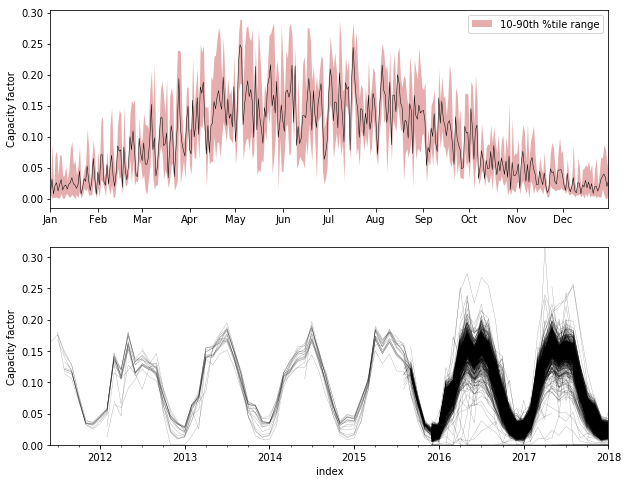

In [4]:
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.dates as mdates
#(2)
#Aggregate results as monthly means
results=[]
for i in range(1,1045):
    try:
        results.append(reads2[reads2.DataMill_ID==i].set_index('index').resample('M').mean().CapacityFactor.dropna())
    except Exception:
        pass
    
#Plot the annual capacity factor profile averaged across all panels
cap_mean=reads2.groupby([(reads2.index.month),(reads2.index.day)]).mean().CapacityFactor#.plot(color='k')
cap_q90=reads2.groupby([(reads2.index.month),(reads2.index.day)]).quantile(.9).CapacityFactor#.plot(color='indianred')
cap_q10=reads2.groupby([(reads2.index.month),(reads2.index.day)]).quantile(.1).CapacityFactor#.plot(color='indianred')

fig, (ax) = plt.subplots(2, 1,figsize=(10,8))
ax[0].fill_between(pd.date_range(start='1/1/2016', end='31/12/2016', freq='D'),cap_q10.values,cap_q90.values,color='indianred',alpha=0.5,linewidth=0.,label='10-90th %tile range')
ax[0].plot(pd.date_range(start='1/1/2016', end='31/12/2016', freq='D'),cap_mean.values,color='k',linewidth=0.5)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0].set_ylabel('Capacity factor')
ax[0].margins(x=0)
ax[0].legend(loc='best')

#Plot the monthly capacity factors for each site
pd.concat(results,axis=1).plot(color='k',alpha=0.5,legend=False,ax=ax[1],linewidth=0.25)
ax[1].set_ylabel('Capacity factor')
ax[1].margins(x=0,y=0)


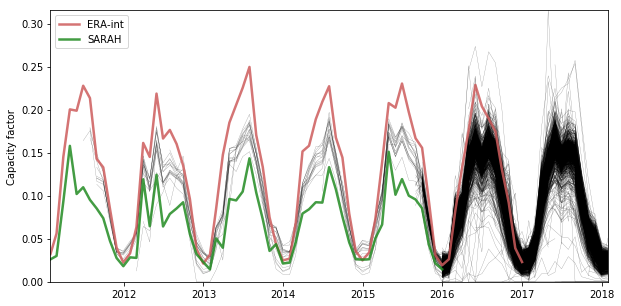

In [8]:
#(3)
'''
PV calculations made following:
T. Huld, M. Súri, E.D. Dunlop, Geographical variation of the conversion effi-
ciency of crystalline silicon photovoltaic modules in Europe, Prog. Photovolt.
Res. Appl. 16 (7) (Nov. 2008) 595e607, http://dx.doi.org/10.1002/pip.846.
'''
############################################################
#Empirical relationship between PV module temp. and air temp
############################################################
#T_mod: PV module temperature
#T_air: Air temperature
#T_noct: Nominal operating cell temperature (48C)
#T_0: Temperature reference value (20C)
#G: Global Horizontal Irradiance
#G_0: Reference Global Horizontal Irradiance (800 W /m2)
T_noct=48.
T_0=20.
G_0=800.

def t_module(G,T_air):
    return T_air+((T_noct-T_0)*(G/G_0))

###########################################################
#Relative module efficiency as a function of t_module and G
###########################################################
#eff_rel: Relative module efficiency
#G_star: G/G_stc, where G_stc= 1000W per m2)
#T_stc: temperature under standard test conditions
#With the constants...
#alpha: 4.2E-3 per Kelvin
#beta: -4.6E-3 per Kelvin
#c1:0.033
#c2:0.0092
T_stc=-10.
alpha= 1.2E-3
beta= -4.6E-3
c1=0.033
c2=-0.0092

def eff_rel(G,T_air):
    return (1+alpha*(t_module(G,T_air)-T_stc))*(1+c1*np.log(G/G_0)+c2*np.power(np.log(G/G_0),2)+beta*t_module(G,T_air))

########################
#Capacity factor (cap_f)
########################
#NB: cap_f = P_G/P_stc = eff_rel . G/G_stc
G_stc=1000.
def cap_f(G,T_air):
    return eff_rel(G,T_air)*(G/G_stc)

#Global Horizontal Irradiance (GHI) for approx. region of Leeds
#Surface Solar Radiation Data Set - Heliosat (SARAH) (https://wui.cmsaf.eu/safira/action/viewDoiDetails?acronym=SARAH_V001)
#(NB: dataset only extends to the year 2011 inclusive)
SARAH_leeds=pd.read_pickle("./SARAH_leeds").resample('h').mean() 

#Global Horizontal Irradiance (GHI) for approx. region of Leeds 
#Bias corrected GHI values derived form ERA-Interim (see EUROPEAN CLIMATIC ENERGY MIXES (ECEM): https://demos.the-iea.org/ecem/pdf/ECEM_VFS_C05_GHI_20171128.pdf)
#(NB: dataset only extends to the year 2016 inclusive)
ERA_GHI_leeds=pd.read_pickle("./ERA_GHI_hourly").resample('h').mean()

#2m air temperature for approx. region of Leeds
#ECMWF ER5 reanalysis(https://software.ecmwf.int/wiki/display/CKB/What+is+ERA5)
temperature_leeds=pd.read_pickle("./temperature_leeds")

###Plot monthly means of estimated and recorded capacity factors
np.warnings.filterwarnings('ignore')
fig, (ax1) = plt.subplots(1, 1,figsize=(10,5))
ax1.plot(pd.concat(results,axis=1),color='k',alpha=0.5,linewidth=0.25,label='')
ax1.plot(cap_f(ERA_GHI_leeds,temperature_leeds-273.15).resample('M').mean(),color='indianred',alpha=0.85,linewidth=2.5,label='ERA-int')
ax1.plot(cap_f(SARAH_leeds,temperature_leeds-273.15).resample('M').mean(),color='forestgreen',alpha=0.85,linewidth=2.5,label='SARAH')
ax1.set_ylabel('Capacity factor')
ax1.margins(x=0,y=0)
ax1.legend(loc='best')

# SARAH underestimates; ERA-interim overestimates.
# Refined estimates could be made using plane-of-array direct, diffuse, and ground-reflected diffuse irradiance values
# These values could be from measurements/approximations of Direct Normal Irradiance and Diffuse Horizontal Irradiance
# Something for another notebook....